![ab_testing_image](ab_testing_image.jpg)

As a Data Scientist at a leading online travel agency, you’ve been tasked with evaluating the impact of a new search ranking algorithm designed to improve conversion rates. The Product team is considering a full rollout, but only if the experiment shows a clear positive effect on the conversion rate and does not lead to a longer time to book.

They have shared A/B test datasets with session-level booking data (`"sessions_data.csv"`) and user-level control/variant split (`"users_data.csv"`). Your job is to analyze and interpret the results to determine whether the new ranking system delivers a statistically significant improvement and provide a clear, data-driven recommendation.

## `sessions_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `session_id` | `string` | Unique session identifier (unique for each row) |
| `user_id` | `string` | Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions) |
| `session_start_timestamp` | `string` | When a session started |
| `booking_timestamp` | `string` | When a booking was made (missing if no booking was made during a session) |
| `time_to_booking` | `float` | time from start of the session to booking, in minutes (missing if no booking was made during a session) |
| `conversion` | `integer` | _New column to create:_ did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1) |

<br>

## `users_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `user_id` | `string` | Unique user identifier (only logged-in users in this table) |
| `experiment_group` | `string` | control / variant split for the experiment (expected to be equal 50/50) |

<br>

The full on criteria are the following:
- Primary metric (conversion) effect must be statistically significant and show positive effect (increase).
- Guardrail (time_to_booking) effect must either be statistically insignificant or show positive effect (decrease)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from pingouin import ttest
from statsmodels.stats.proportion import proportions_ztest

In [59]:
sessions = pd.read_csv('sessions_data.csv')
users = pd.read_csv('users_data.csv')

In [60]:
print(sessions.head(5))
print(sessions.info())
print(sessions.describe())

         session_id           user_id  ... booking_timestamp time_to_booking
0  CP0lbAGnb5UNi3Ut  TcCIMrtQ75wHGXVj  ...               NaN             NaN
1  UQAjrPYair63L1p8  TcCIMrtQ75wHGXVj  ...               NaN             NaN
2  9zQrAPxV5oi2SzSa  TcCIMrtQ75wHGXVj  ...               NaN             NaN
3  kkrz1M5vxrQ8wXRZ  GUGVzto9KGqeX3dc  ...               NaN             NaN
4  AKDXZWWFYKViHC27               NaN  ...               NaN             NaN

[5 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16981 entries, 0 to 16980
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               16981 non-null  object 
 1   user_id                  15283 non-null  object 
 2   session_start_timestamp  16981 non-null  object 
 3   booking_timestamp        2844 non-null   object 
 4   time_to_booking          2844 non-null   float64
dtypes: float64(1), object(4)


There are 16981 booking sessions in total (for both versions of ranking algorithm), consisting 15283 sessions from logged-in users and 1698 non logged-in sessions. Only 2844 (about 16.748%) sessions end up with a booking. The booking time ranges from about 4.91 minutes to about 46.99 minutes, with average value about 14.94 minutes. The booking time of a large fraction (75%) of the effective sessions is below 18 minutes.     

In [61]:
print(users.head(6))
print(users.info())

            user_id experiment_group
0  TcCIMrtQ75wHGXVj          variant
1  GUGVzto9KGqeX3dc          variant
2  uNcuV49WhPJ8C0MH          variant
3  v2EBIHmOdQfalI6k          variant
4  wnsKpRB9SE0gTZAq          variant
5  go0Nl2hbR6L3zYu4          variant
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           10000 non-null  object
 1   experiment_group  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None


### Your solution

In [62]:
confidence_level = 0.90  # Set the pre-defined confidence level (90%)
alpha = 1 - confidence_level  # Significance level for hypothesis tests

In [63]:
#----------------- Join two datasets --------------------#
# initiate sessions_x_users dataframe 
sessions_x_users = sessions.copy()

# remove non logged-in users
sessions_x_users = sessions_x_users.dropna(axis=0,subset=['user_id']).reset_index(drop=True)

# adding experiment group 
sessions_x_users = sessions_x_users.merge(users, on='user_id', how='left')
sessions_x_users = sessions_x_users.dropna(axis=0,subset=['experiment_group']).reset_index(drop=True) 

# create conversion columns
sessions_x_users["conversion"] = sessions_x_users["time_to_booking"].notna() 
sessions_x_users["conversion"] = sessions_x_users["conversion"].astype(int)
print(sessions_x_users[["time_to_booking","conversion"]].tail(10))

       time_to_booking  conversion
15273              NaN           0
15274              NaN           0
15275        13.494931           1
15276              NaN           0
15277              NaN           0
15278              NaN           0
15279              NaN           0
15280              NaN           0
15281              NaN           0
15282         8.534696           1


1215


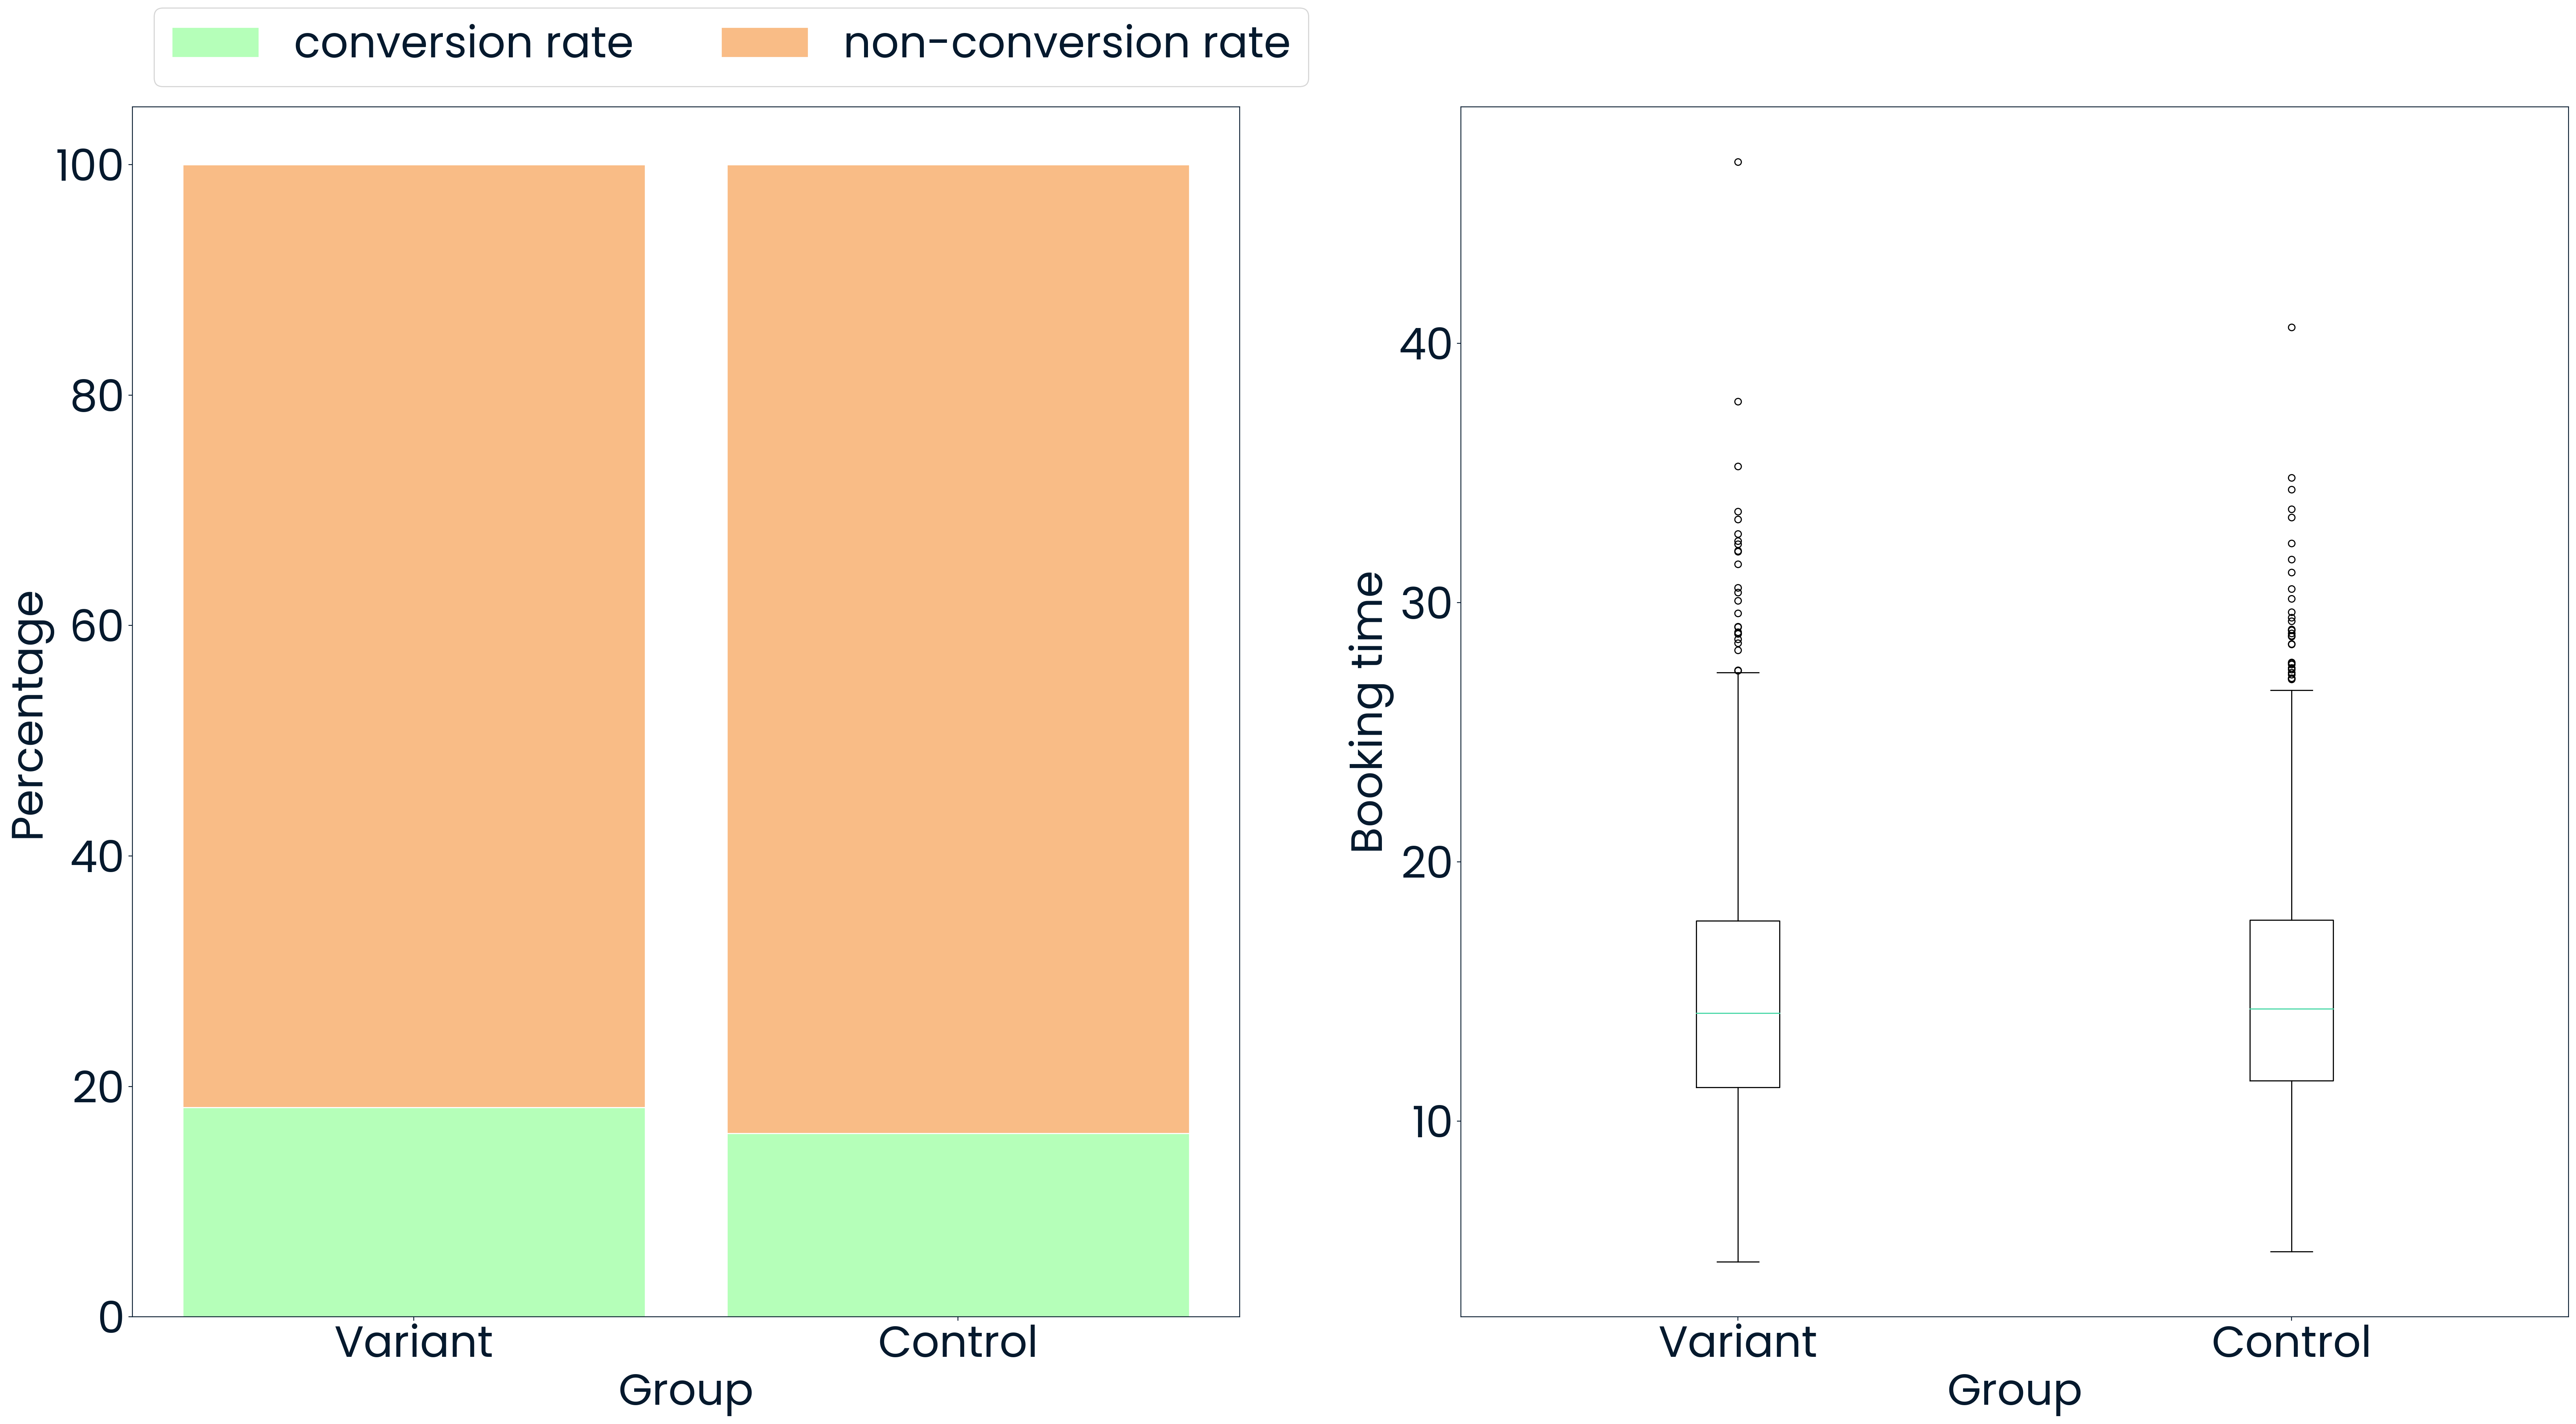

In [64]:
# control/variant split
control_conversion = sessions_x_users[sessions_x_users['experiment_group'] == 'control']['conversion']
variant_conversion = sessions_x_users[sessions_x_users['experiment_group'] == 'variant']['conversion']
control_booking_time = sessions_x_users[sessions_x_users['experiment_group'] == 'control']['time_to_booking']
control_booking_time.dropna(inplace=True)
variant_booking_time = sessions_x_users[sessions_x_users['experiment_group'] == 'variant']['time_to_booking'] 
variant_booking_time.dropna(inplace=True)

# plot for visualization
x = [1,2]
names = ('Variant', 'Control')
gain_rate = [100*variant_conversion.mean(), 100*control_conversion.mean()]
loss_rate = [100*(1-variant_conversion.mean()), 100*(1-control_conversion.mean())]



fig, axs = plt.subplots(1,2, figsize=(40,20))
plt.rcParams.update({'font.size': 40})
axs[0].bar(x,gain_rate, color='#b5ffb9', edgecolor='white', width=0.85, label="conversion rate")
axs[0].bar(x,loss_rate, bottom=gain_rate, color='#f9bc86', edgecolor='white', width=0.85, label="non-conversion rate")
axs[0].set_xticks(x, names)
axs[0].set_xlabel("Group")
axs[0].set_ylabel("Percentage")
axs[0].legend(loc='upper left', bbox_to_anchor=(0,1.1), ncol=2)

axs[1].boxplot([variant_booking_time, control_booking_time])
axs[1].set_xlabel("Group")
axs[1].set_ylabel("Booking time")
axs[1].set_xticks(x, names)
print(control_conversion.astype(bool).sum())


There is a slightly (positive) change in the conversion rate for the variant. The change in booking time seems to be insignificant. Now we are turning to perform the A/B test.

In [65]:
# sanity check for Sample Ratio Mismatch (SRM) between control and variant 
nobs = [control_conversion.count(), variant_conversion.count()]
N = sum(nobs)
nexp = [N/2,N/2]
chi2, srm_chi2_pval = chisquare(f_obs=nobs, f_exp=nexp)
print(chi2, srm_chi2_pval)

if srm_chi2_pval < alpha:
    print("SRM is statistically significant!")
else:
    print("SRM is NOT statistically significant!")

0.034613622979781454 0.852407615775466
SRM is NOT statistically significant!


In [66]:
# Proportion z-test for binary conversion (0,1)
print("control conversion rate: ", control_conversion.mean().round(3))
print("variant conversion rate: ", variant_conversion.mean().round(3))
effect_size_primary = (variant_conversion.mean() - control_conversion.mean())/control_conversion.mean()
effect_size_primary = effect_size_primary.round(3)
if (effect_size_primary>0):
    print(f"Positive effect: The conversion rate increases with an effect size of {effect_size_primary}!")
else:
    print("Negative effect: The conversion rate does not increase!")
gain = [control_conversion.astype(bool).sum(), variant_conversion.astype(bool).sum()]
nobs = [control_conversion.count(), variant_conversion.count()]
print(gain)
print(nobs)
stat, pval_primary = proportions_ztest(count=gain, nobs=nobs, alternative='two-sided')
if pval_primary < alpha:
    print("The change in conversion rate is statistically significant!")
else:
    print("The change in conversion rate is NOT statistically significant!")

###
if (effect_size_primary>0) and (pval_primary < alpha):
    first_criterion = True
else:
    first_criterion = False

control conversion rate:  0.159
variant conversion rate:  0.182
Positive effect: The conversion rate increases with an effect size of 0.142!
[1215, 1392]
[7630, 7653]
The change in conversion rate is statistically significant!


In [67]:
# Mean t-test for booking time
print("Mean control booking time: ", control_booking_time.mean())
print("Mean variant booking time: ", variant_booking_time.mean())
effect_size_guardrail= (variant_booking_time.mean() - control_booking_time.mean())/control_booking_time.mean()
effect_size_guardrail = effect_size_guardrail.round(3)
print("Effective size: ", effect_size_guardrail)

res = ttest(control_booking_time, variant_booking_time, confidence=confidence_level)
pval_guardrail = res['p-val'].values[0]
if pval_guardrail < alpha:
    print("Guardrail (time_to_booking) effect is statistically significant!")
else:
    print("Guardrail (time_to_booking) effect is statistically insignificant!")

###
if (effect_size_guardrail<0) or (pval_guardrail >= alpha):
    second_criterion = True
else:
    second_criterion = False

Mean control booking time:  15.012403966770629
Mean variant booking time:  14.894028712999187
Effective size:  -0.008
Guardrail (time_to_booking) effect is statistically insignificant!


In [68]:
if (first_criterion == True) and (second_criterion == True):
    decision_full_on = "Yes"
else:
    decision_full_on = "No"

print("Decision to go full on? ", decision_full_on)

Decision to go full on?  Yes


Test results:
- There is a positive effect in conversion rate. This change is tested to be statistically significant!
- There is a slighly change in the mean time to booking (decrease), but this change is statistically insignificant!

Conclusion: The new ranking system delivers a statistically significant improvement in conversion rate and does not results in a statistically significant longer time for booking. Therefore, I would highly recommend to to go full on with this new system.  